In [ ]:
import os

# ==========================================
# 1. 设置下载路径为 Colab 本地 (避开 Drive 报错)
# ==========================================
dest_path = "/content/chimera_data"
if not os.path.exists(dest_path):
    os.makedirs(dest_path)

# ==========================================
# 2. 安装 AWS CLI
# ==========================================
!pip install awscli -q

# ==========================================
# 3. 执行下载 (只下你需要的文件)
# ==========================================
print("🚀 开始下载数据...")
!aws s3 sync --no-sign-request \
  s3://chimera-challenge/v2/task3/data/ \
  "{dest_path}" \
  --exclude "*" \
  --include "*_RNA.json" \
  --include "*_CD.json" \
  --include "task3_quality_control.csv"

print(f"\n✅ 下载完成！文件保存在: {dest_path}")
print("👀 请点击左侧文件夹图标，找到 'chimera_data' 文件夹查看数据")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
🚀 开始下载数据...
download: s3://chimera-challenge/v2/task3/data/3A_002/3A_002_CD.json to chimera_data/3A_002/3A_002_CD.json
download: s3://chimera-challenge/v2/task3/data/3A_001/3A_001_CD.json to chimera_data/3A_001/3A_001_CD.json
download: s3://chimera-challenge/v2/task3/data/3A_005/3A_005_CD.json to chimera_data/3A_005/3A_005_CD.json
download: s3://chimera-challenge/v2/task3/data/3A_003/3A_003_CD.json to chimera_d

In [ ]:
import os
import glob
import json
import pandas as pd

# ==========================================
# 1. 自动寻找数据文件 (无论在哪都能找到)
# ==========================================
print("🔍 正在搜索 JSON 文件...")

# 从当前目录递归搜索所有 _CD.json 文件
# 这是一个"暴力搜索"，确保只要文件在 Colab 里就能找到
search_patterns = [
    "/content/**/*_CD.json",            # 搜索 content 下所有子目录
    "/content/drive/MyDrive/**/*_CD.json" # 同时也搜 Drive (如果你挂载了)
]

cd_files = []
for pattern in search_patterns:
    found = glob.glob(pattern, recursive=True)
    cd_files.extend(found)

# 去重
cd_files = list(set(cd_files))

if len(cd_files) == 0:
    print("❌ 错误: 没找到任何 '*_CD.json' 文件！")
    print("请检查: 1. AWS 下载命令是否执行成功？")
    print("       2. 左侧文件夹栏里能看到文件名吗？")
    # 停止运行，避免后面的 KeyError
else:
    print(f"✅ 成功找到 {len(cd_files)} 个临床数据文件！")
    print(f"文件示例: {cd_files[:3]}")

    # ==========================================
    # 2. 读取并合并数据
    # ==========================================
    data_list = []
    for file in cd_files:
        try:
            with open(file, 'r') as f:
                d = json.load(f)
                # 从文件名提取 ID，例如 "/content/data/3A_001_CD.json" -> "3A_001"
                file_name = os.path.basename(file)
                patient_id = file_name.replace('_CD.json', '')

                d['Patient_ID'] = patient_id
                data_list.append(d)
        except Exception as e:
            print(f"⚠️ 跳过坏文件 {file}: {e}")

    # ==========================================
    # 3. 转换为 DataFrame 并统计缺失值
    # ==========================================
    if len(data_list) > 0:
        df = pd.DataFrame(data_list)
        df = df.set_index('Patient_ID')

        print("\n" + "="*40)
        print(f"📊 统计报告 (基于 {len(df)} 个样本)")
        print("="*40)

        # 统计空值 (NaN)
        missing = df.isnull().sum()
        missing = missing[missing > 0]

        if len(missing) == 0:
            print("1. 基础检查: ✅ 没有发现 NaN/None 空值")
        else:
            print("1. 基础检查: 发现以下列有缺失:")
            print(missing)

        # 统计文本占位符 (Unknown, NA)
        print("\n2. 深度检查 (Unknown/NA):")
        placeholders = ['Unknown', 'unknown', 'NA', 'n/a', 'Not Reported', '?']
        found_placeholder = False
        for col in df.select_dtypes(include=['object']).columns:
            count = df[col].isin(placeholders).sum()
            if count > 0:
                found_placeholder = True
                print(f"   - {col}: 包含 {count} 个 '{placeholders[0]}...' 类的值")

        if not found_placeholder:
            print("   ✅ 没有发现明显的文本缺失标记")

        print("-" * 40)
        print("数据预览:")
        print(df.head(3))

🔍 正在搜索 JSON 文件...
✅ 成功找到 176 个临床数据文件！
文件示例: ['/content/chimera_data/3A_060/3A_060_CD.json', '/content/chimera_data/3A_074/3A_074_CD.json', '/content/chimera_data/3A_005/3A_005_CD.json']

📊 统计报告 (基于 176 个样本)
1. 基础检查: ✅ 没有发现 NaN/None 空值

2. 深度检查 (Unknown/NA):
   ✅ 没有发现明显的文本缺失标记
----------------------------------------
数据预览:
            age   sex smoking    tumor stage substage grade reTUR LVI variant  \
Patient_ID                                                                      
3A_060       88  Male      No  Primary  T1HG      T1e    G3   Yes  No     UCC   
3A_074       74  Male      No  Primary  T1HG      T1m    G3    No  No     UCC   
3A_005       66  Male     Yes  Primary  T1HG      T1m    G3   Yes  No     UCC   

                   EORTC  no_instillations   BRS  progression  \
Patient_ID                                                      
3A_060      Highest risk              12.0  BRS3            1   
3A_074         High risk              24.0  BRS2            0   
3A_005    

🚀 正在初始化数据调查...
⚠️ 警告: 未找到 task3_quality_control.csv，将分析所有样本

📋 正在分析 Clinical Data...
✅ 有效临床样本数: 176

[Clinical 特点 1: 目标变量分布]
progression
0    0.636364
1    0.363636
Name: proportion, dtype: float64

[Clinical 特点 2: 关键类别分布]
stage
T1HG    164
TaHG     12
Name: count, dtype: int64


/tmp/ipython-input-4167812141.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='progression', data=df_cd, ax=axes[0], palette='viridis')
/tmp/ipython-input-4167812141.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='EORTC', data=df_cd, ax=axes[1], palette='magma')


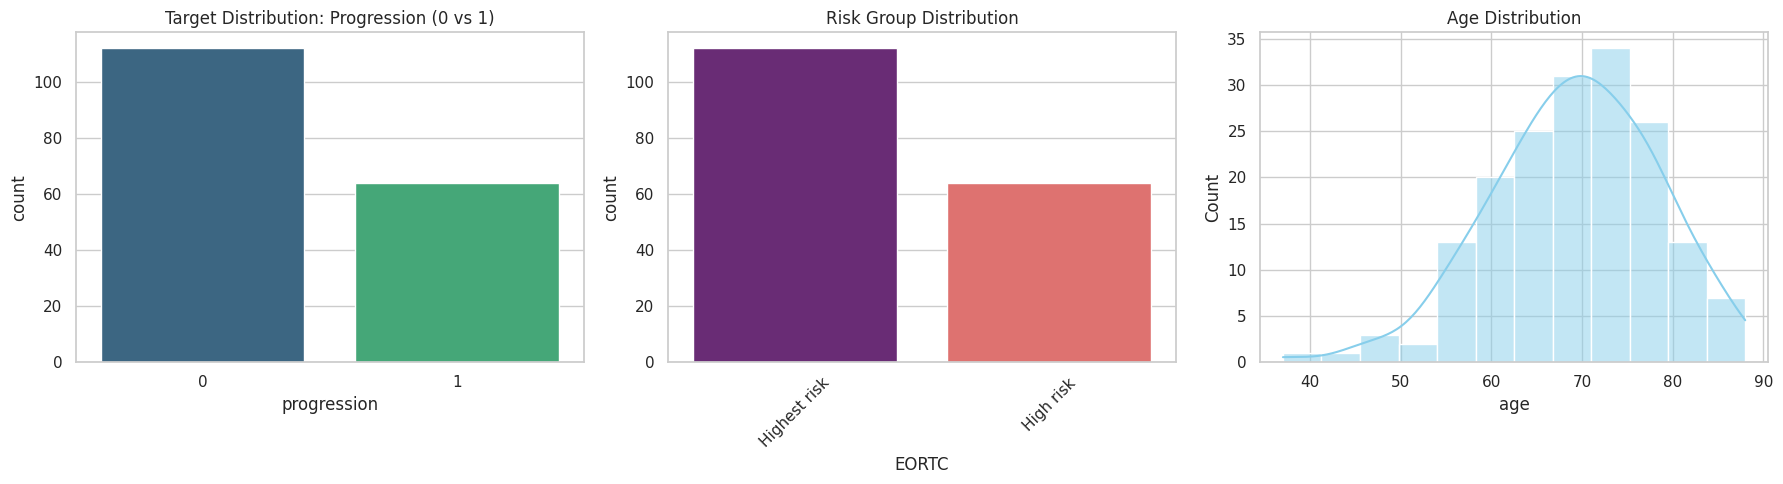


🧬 正在分析 RNA Data (这可能需要几十秒)...


100%|██████████| 176/176 [00:02<00:00, 63.63it/s]



✅ RNA 矩阵形状: (176, 19359)
[RNA 特点 1: 数值范围]
Min: 3.69, Max: 21.20, Mean: 7.68
[RNA 特点 2: 基因活跃度]
方差极低的基因数量 (<0.1): 0 个 (可能是噪音或持家基因)


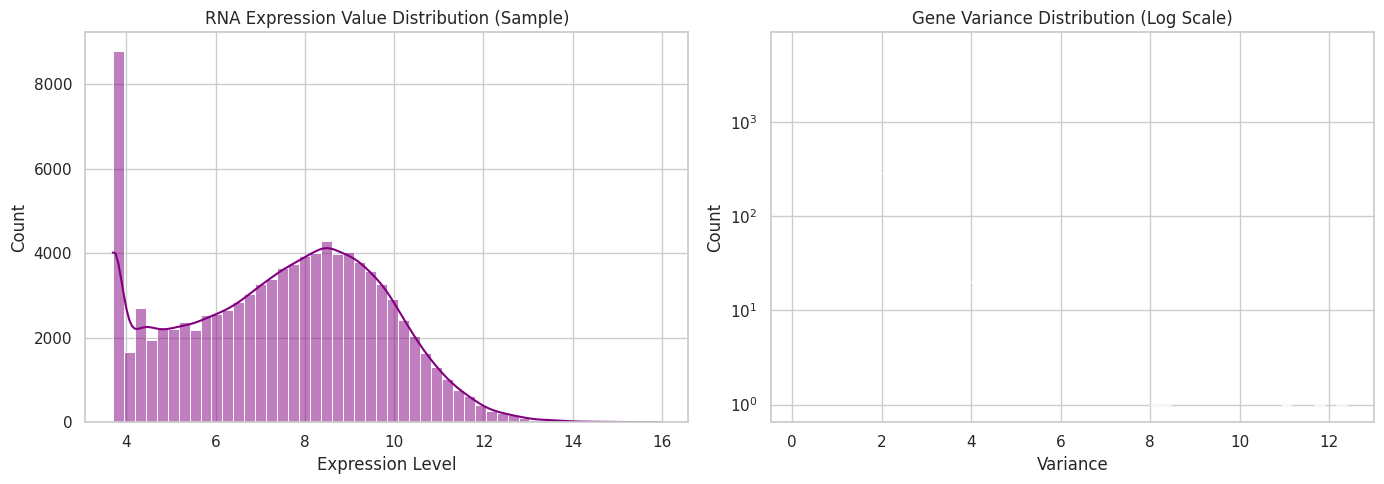


🎉 调查完成！请根据图表更新你的文档。


In [ ]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 设置绘图风格
sns.set(style="whitegrid")

# ==========================================
# 1. 数据加载与质量过滤 (基础设置)
# ==========================================
print("🚀 正在初始化数据调查...")

# 自动寻找文件路径
search_patterns = ["/content/**/*_CD.json", "/content/chimera_data/**/*_CD.json"]
cd_files = []
for pattern in search_patterns:
    cd_files.extend(glob.glob(pattern, recursive=True))
cd_files = list(set(cd_files))

# 读取 QC 文件以排除坏样本
try:
    qc_df = pd.read_csv("task3_quality_control.csv")
    bad_patients = qc_df[qc_df['wsi_quality'] == 'Poor']['chimera_id_t3'].tolist()
    print(f"📋 QC信息: 发现 {len(bad_patients)} 个低质量样本 (将被排除)")
except:
    print("⚠️ 警告: 未找到 task3_quality_control.csv，将分析所有样本")
    bad_patients = []

# ==========================================
# 2. Clinical Data 深度调查
# ==========================================
print("\n📋 正在分析 Clinical Data...")
clinical_data = []

for file in cd_files:
    p_id = os.path.basename(file).replace('_CD.json', '')
    if p_id in bad_patients: continue # 跳过坏样本

    with open(file, 'r') as f:
        d = json.load(f)
        d['Patient_ID'] = p_id
        clinical_data.append(d)

df_cd = pd.DataFrame(clinical_data).set_index('Patient_ID')

# --- 统计输出 ---
print(f"✅ 有效临床样本数: {len(df_cd)}")
print("\n[Clinical 特点 1: 目标变量分布]")
print(df_cd['progression'].value_counts(normalize=True))

print("\n[Clinical 特点 2: 关键类别分布]")
print(df_cd['stage'].value_counts())

# --- 可视化 1: 临床数据分布 ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 目标分布
sns.countplot(x='progression', data=df_cd, ax=axes[0], palette='viridis')
axes[0].set_title('Target Distribution: Progression (0 vs 1)')

# 风险等级
sns.countplot(x='EORTC', data=df_cd, ax=axes[1], palette='magma')
axes[1].set_title('Risk Group Distribution')
axes[1].tick_params(axis='x', rotation=45)

# 数值变量: 年龄
sns.histplot(df_cd['age'], kde=True, ax=axes[2], color='skyblue')
axes[2].set_title('Age Distribution')

plt.tight_layout()
plt.show()

# ==========================================
# 3. RNA Data 深度调查
# ==========================================
print("\n🧬 正在分析 RNA Data (这可能需要几十秒)...")

# 找到对应的 RNA 文件
rna_values_flat = [] # 用来存所有数值看分布
gene_variances = {}  # 用来存基因方差

# 为了速度，我们只抽样分析前 50 个样本的数值分布
# 但会计算所有基因的平均值来检查是否存在"死基因"
sample_count = 0
rna_matrix = []

for p_id in tqdm(df_cd.index): # 确保只读刚才那些有效病人
    # 找文件
    # 假设文件就在同目录下
    rna_file = glob.glob(f"/content/**/{p_id}_RNA.json", recursive=True)
    if not rna_file: continue

    with open(rna_file[0], 'r') as f:
        r_data = json.load(f)
        vals = list(r_data.values())
        rna_matrix.append(vals)

        # 只取前 5 个样本来画全部分布图 (太大会卡死)
        if sample_count < 5:
            rna_values_flat.extend(vals)
        sample_count += 1

# 转 numpy 加速计算
rna_matrix = np.array(rna_matrix) # Shape: (N_patients, N_genes)

# --- 统计输出 ---
print(f"\n✅ RNA 矩阵形状: {rna_matrix.shape}")
print(f"[RNA 特点 1: 数值范围]")
print(f"Min: {np.min(rna_matrix):.2f}, Max: {np.max(rna_matrix):.2f}, Mean: {np.mean(rna_matrix):.2f}")

gene_vars = np.var(rna_matrix, axis=0)
print(f"[RNA 特点 2: 基因活跃度]")
print(f"方差极低的基因数量 (<0.1): {np.sum(gene_vars < 0.1)} 个 (可能是噪音或持家基因)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(rna_values_flat, bins=50, kde=True, ax=axes[0], color='purple')
axes[0].set_title('RNA Expression Value Distribution (Sample)')
axes[0].set_xlabel('Expression Level')

sns.histplot(gene_vars, bins=50, log_scale=(False, True), ax=axes[1], color='orange')
axes[1].set_title('Gene Variance Distribution (Log Scale)')
axes[1].set_xlabel('Variance')

plt.tight_layout()
plt.show()

print("\n🎉 调查完成！请根据图表更新你的文档。")

In [ ]:
import pandas as pd
import json
import glob
import os
import numpy as np
# from sklearn.decomposition import PCA # 移除 PCA 导入
# from sklearn.preprocessing import StandardScaler # 移除 StandardScaler 导入
from google.colab import files # 用于自动下载

print("🚀 开始全盘扫描并生成最终数据...")

# ==========================================
# 1. 强制搜索 QC 文件 (无论在哪)
# ==========================================
print("🔍 正在搜索 task3_quality_control.csv ...")
qc_files = glob.glob("/content/**/task3_quality_control.csv", recursive=True)

if not qc_files:
    raise FileNotFoundError("❌ 致命错误: 找不到 task3_quality_control.csv！请确认你已经上传或下载了该文件。")
else:
    qc_path = qc_files[0]
    print(f"✅ 找到 QC 文件: {qc_path}")
    qc_df = pd.read_csv(qc_path)
    # 获取坏人名单
    bad_ids = qc_df[qc_df['wsi_quality'] == 'Poor']['chimera_id_t3'].tolist()
    print(f"🚫 已加载排除名单: {len(bad_ids)} 个低质量样本")

# ==========================================
# 2. 强制搜集所有数据文件 (全盘递归搜索)
# ==========================================
print("🔍 正在全盘搜索 JSON 数据 (这可能需要几秒钟)...")

# 直接搜 /content 下的所有角落
all_cd_files = glob.glob("/content/**/*_CD.json", recursive=True)
all_rna_files = glob.glob("/content/**/*_RNA.json", recursive=True)

# 去重 (防止软链接导致重复)
all_cd_files = list(set(all_cd_files))
all_rna_files = list(set(all_rna_files))

print(f"📂 找到 Clinical 文件: {len(all_cd_files)} 个")
print(f"📂 找到 RNA 文件: {len(all_rna_files)} 个")

if len(all_cd_files) == 0:
    raise FileNotFoundError("❌ 没找到任何 _CD.json 文件！请检查之前的下载步骤是否成功。")

# ==========================================
# 3. 处理 Clinical Data
# ==========================================
clinical_list = []

for file in all_cd_files:
    # 提取 ID
    file_name = os.path.basename(file)
    p_id = file_name.replace('_CD.json', '')

    # 排除坏人
    if p_id in bad_ids:
        continue

    try:
        with open(file, 'r') as f:
            d = json.load(f)
            d['Patient_ID'] = p_id
            clinical_list.append(d)
    except Exception as e:
        print(f"⚠️ 读取错误 {file}: {e}")

df_clinical = pd.DataFrame(clinical_list).set_index('Patient_ID')

# 排序并获取最终 ID 列表
valid_ids = sorted(df_clinical.index.tolist())
df_clinical = df_clinical.loc[valid_ids]

print(f"✅ Clinical 清洗完毕: 最终样本数 {df_clinical.shape[0]} (目标是 163)")

# 保存 Clinical 结果
df_clinical[['progression', 'Time_to_prog_or_FUend']].to_csv('/content/target_labels.csv')

features = df_clinical.drop(columns=['progression', 'Time_to_prog_or_FUend'])
df_clinical_encoded = pd.get_dummies(features, drop_first=True)
df_clinical_encoded.to_csv('/content/clinical_processed.csv')

# ==========================================
# 4. 处理 RNA Data (优化匹配逻辑, 不做 PCA)
# ==========================================
print("🧬 正在匹配并处理 RNA 数据...")

# 创建一个文件名映射字典，查找速度更快更准
# 格式: {'3A_001': '/path/to/3A_001_RNA.json'}
rna_map = {}
for f in all_rna_files:
    fname = os.path.basename(f)
    pid = fname.replace('_RNA.json', '')
    rna_map[pid] = f

rna_data_list = [] # 存储 RNA 原始数据
rna_gene_names = [] # 存储基因名称 (假设所有文件基因顺序一致)
missing_rna_count = 0

for p_id in valid_ids:
    if p_id in rna_map:
        with open(rna_map[p_id], 'r') as f:
            d = json.load(f)
            if not rna_gene_names:
                rna_gene_names = list(d.keys()) # 获取基因名称
            rna_data_list.append(list(d.values()))
    else:
        print(f"⚠️ 警告: 找不到病人 {p_id} 的 RNA 文件！")
        missing_rna_count += 1
        # 填充 0 或者均值防止报错 (这里暂时填0)
        # 实际操作中，如果基因名称数量不确定，需要更严谨的处理
        if rna_gene_names: # 确保已获取基因名称列表
            rna_data_list.append([0] * len(rna_gene_names))
        else:
            # 如果第一个RNA文件都还没读到，无法确定基因数量，暂时跳过或报错
            print(f"❌ 无法确定基因数量，跳过 {p_id} 的 RNA 数据填充")

if missing_rna_count > 0:
    print(f"⚠️ 总共有 {missing_rna_count} 个样本缺失 RNA 数据")

# 转 DataFrame
df_rna_raw = pd.DataFrame(rna_data_list, index=valid_ids, columns=rna_gene_names)

# 保存 RNA 原始数据
df_rna_raw.to_csv('/content/rna_expression_raw.csv')

print(f"✅ RNA 原始数据处理完毕并保存到 rna_expression_raw.csv: {df_rna_raw.shape}")

# ==========================================
# 5. 自动触发下载
# ==========================================
print("\n🎉 全部完成！正在自动下载 3 个文件到你的电脑...")
try:
    files.download('/content/clinical_processed.csv')
    files.download('/content/rna_expression_raw.csv') # 下载原始 RNA 数据
    files.download('/content/target_labels.csv')
except Exception as e:
    print("⚠️ 自动下载被浏览器拦截，请手动在左侧文件栏下载。")


🚀 开始全盘扫描并生成最终数据...
🔍 正在搜索 task3_quality_control.csv ...
✅ 找到 QC 文件: /content/chimera_data/task3_quality_control.csv
🚫 已加载排除名单: 13 个低质量样本
🔍 正在全盘搜索 JSON 数据 (这可能需要几秒钟)...
📂 找到 Clinical 文件: 176 个
📂 找到 RNA 文件: 176 个
✅ Clinical 清洗完毕: 最终样本数 163 (目标是 163)
🧬 正在匹配并处理 RNA 数据...
✅ RNA 原始数据处理完毕并保存到 rna_expression_raw.csv: (163, 19359)

🎉 全部完成！正在自动下载 3 个文件到你的电脑...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔄 正在重新计算 PCA 方差分布...


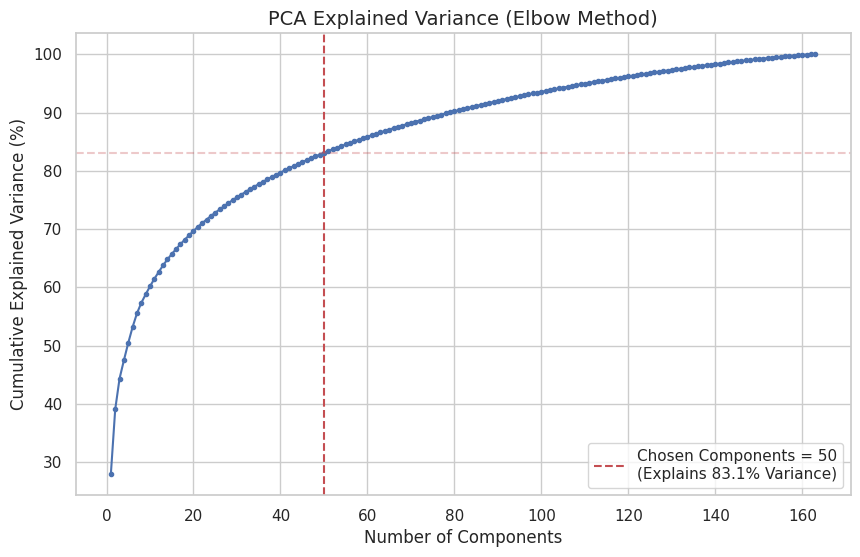


📊 统计结果:
前 50 个主成分解释了原始数据 83.08% 的方差。
✅ 结论: 这是一个非常好的比例！说明 50 维保留了大部分关键信息。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 重新加载刚才生成的 RNA 数据 (原始的, 为了重新跑 PCA 分析)
# 这一步是为了计算"解释方差比"，我们刚才保存的csv已经是结果了，里面没有这个统计数字
# 所以我们得快速重新拟合一下
import glob
import json
import os

# 快速读取 RNA 数据 (复用之前的逻辑)
print("🔄 正在重新计算 PCA 方差分布...")
valid_ids = pd.read_csv('clinical_processed.csv')['Patient_ID'].tolist()
rna_data = []
# 使用之前的 rna_map (如果没有运行上一段，这里可能报错，所以我重新简单构建一下)
all_rna_files = glob.glob("/content/**/*_RNA.json", recursive=True)
rna_map = {os.path.basename(f).replace('_RNA.json', ''): f for f in all_rna_files}

for pid in valid_ids:
    with open(rna_map[pid], 'r') as f:
        rna_data.append(list(json.load(f).values()))

X = np.array(rna_data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 拟合 PCA (不限制维度，看看到底多少维合适)
pca_full = PCA(n_components=163) # 最大只能是样本数 163
pca_full.fit(X_scaled)

# 3. 计算累计解释方差 (Cumulative Explained Variance)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_) * 100
var_at_50 = cumulative_variance[49] # 第50个点的数值 (索引从0开始)

# 4. 画图 (Scree Plot)
plt.figure(figsize=(10, 6))

plt.plot(range(1, 164), cumulative_variance, marker='.', linestyle='-', color='b')
plt.axvline(x=50, color='r', linestyle='--', label=f'Chosen Components = 50\n(Explains {var_at_50:.1f}% Variance)')
plt.axhline(y=var_at_50, color='r', linestyle='--', alpha=0.3)

plt.title('PCA Explained Variance (Elbow Method)', fontsize=14)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.legend()
plt.show()

print(f"\n📊 统计结果:")
print(f"前 50 个主成分解释了原始数据 {var_at_50:.2f}% 的方差。")
if var_at_50 > 60:
    print("✅ 结论: 这是一个非常好的比例！说明 50 维保留了大部分关键信息。")
else:
    print("⚠️ 结论: 信息量稍低，可能 RNA 数据噪声较大，但考虑到样本量限制，50 仍是合理选择。")


In [ ]:
import pandas as pd

# 加载 clinical_processed.csv
df_clinical_encoded = pd.read_csv('/content/clinical_processed.csv', index_col='Patient_ID')

# 加载 rna_embedding_50d.csv
df_rna_emb = pd.read_csv('/content/rna_embedding_50d.csv', index_col=0)

# 合并两个 DataFrame
df_merged = pd.merge(df_clinical_encoded, df_rna_emb, left_index=True, right_index=True)

print("✅ Clinical 和 RNA 数据已成功合并！")
print(f"合并后的数据形状: {df_merged.shape}")

# 显示合并后的数据前5行
display(df_merged.head())

✅ Clinical 和 RNA 数据已成功合并！
合并后的数据形状: (163, 66)


,age,no_instillations,sex_Male,smoking_No,smoking_Yes,stage_TaHG,substage_T1e,substage_T1m,grade_G3,reTUR_Yes,...,RNA_PC_40,RNA_PC_41,RNA_PC_42,RNA_PC_43,RNA_PC_44,RNA_PC_45,RNA_PC_46,RNA_PC_47,RNA_PC_48,RNA_PC_49
Patient_ID,,,,,,,,,,,,,,,,,,,,,
3A_001,72,24.0,True,True,False,False,False,True,True,True,...,9.059029,-3.821276,-6.099175,8.130615,-6.383013,-7.601961,-7.422575,2.724786,-17.509165,11.617546
3A_002,59,27.0,True,True,False,False,True,False,True,True,...,5.000224,0.236081,-1.256768,-1.045596,-4.779713,-1.824656,-13.586836,4.167994,-3.377355,5.943743
3A_003,73,15.0,True,False,True,False,True,False,True,False,...,-1.965492,-6.424457,10.153501,1.842493,3.282950,-3.216955,12.554961,-8.787364,3.510148,-0.323629
3A_004,63,27.0,False,True,False,False,True,False,True,False,...,-16.537607,12.141615,15.913189,19.866252,4.291552,4.937056,8.204216,-5.872670,-4.160944,-12.174821
3A_005,66,6.0,True,False,True,False,False,True,True,True,...,-0.665744,-9.725037,10.044774,-1.281870,3.262234,2.521163,-1.016171,7.499793,-9.390981,-5.345306


In [ ]:
!apt-get -qq update
!apt-get -qq install -y git-lfs
!git lfs install

!git clone https://github.com/greenelab/tybalt.git
%cd tybalt

# 如果 repo 用了 LFS 放权重/大文件，这步会把它们拉下来
!git lfs pull

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
fatal: destination path 'tybalt' already exists and is not an empty directory.
/content/tybalt


In [ ]:
!pip -q install pandas numpy scikit-learn tensorflow==2.15.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

RNA_CSV = "/content/rna_seq_raw.csv"  # 你的文件路径

df = pd.read_csv(RNA_CSV)

# ✅ 强制把第一列当 index（病人 ID）
df = df.set_index(df.columns[0])

# ✅ 确保剩下全是数值
df = df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

print(df.shape)          # (163, 19359) 你看到的就是这个
print(df.index[:5])      # 应该是 3A_001 这种
print(df.columns[:5])    # 应该是 gene 名

(163, 19359)
Index(['3A_001', '3A_002', '3A_003', '3A_004', '3A_005'], dtype='object', name='Unnamed: 0')
Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2'], dtype='object')


In [ ]:
X = np.log1p(df.values.astype(np.float32))
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X).astype(np.float32)

print("Xz:", Xz.shape)  # (163, 19359)

Xz: (163, 19359)


In [ ]:
!pip -q install tensorflow==2.15.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

WEIGHTS = "/content/encoder_onehidden_vae.hdf5"

def build_encoder_5000_to_100():
    inp = keras.Input(shape=(5000,), name="input_1")
    x = layers.Dense(100, name="dense_1")(inp)
    x = layers.BatchNormalization(name="batch_normalization_1")(x)
    out = layers.Activation("relu", name="activation_1")(x)
    return keras.Model(inp, out, name="encoder")

encoder = build_encoder_5000_to_100()
encoder.load_weights(WEIGHTS)

Z = encoder.predict(X5000, batch_size=64, verbose=1)
print("Z:", Z.shape)  # (163, 100)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Z: (163, 100)


In [ ]:
# =========================
# TyBALT-style VAE for Chimera RNA-seq (single-run script)
# - Input:  /content/rna_seq_raw.csv  (rows=patient_id like 3A_001, cols=genes)
# - Output: /content/chimera_rna_tybalt_latent.tsv
#           /content/models/encoder_onehidden_vae.hdf5
# =========================

# ---- (0) Install deps (Colab usually already has these; safe to run)
!pip -q install --upgrade "tensorflow>=2.12" pandas numpy scikit-learn matplotlib seaborn tqdm

import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback

# -------------------------
# (1) Reproducibility
# -------------------------
np.random.seed(123)
tf.random.set_seed(123)

# -------------------------
# (2) Load Chimera RNA-seq
# -------------------------
RNA_CSV = "/content/rna_seq_raw.csv"  #

rnaseq_df = pd.read_csv(RNA_CSV, index_col=0)
rnaseq_df.index = rnaseq_df.index.astype(str)
rnaseq_df = rnaseq_df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

print("Raw Chimera RNA shape:", rnaseq_df.shape)
print("Index example:", rnaseq_df.index[:5].tolist())
print("Gene example:", rnaseq_df.columns[:5].tolist())

# -------------------------
# (3) Preprocess (match TyBALT "scaled_zeroone" expectation)
#     - log1p(counts)
#     - z-score per gene (across samples)
#     - min-max to [0,1] per gene (for sigmoid decoder)
# -------------------------
X = rnaseq_df.values.astype(np.float32)
#X = np.log1p(X) #chimera already logged i think

# z-score per gene: fit on samples => standardize columns
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# minmax per gene to [0,1]
X01 = MinMaxScaler(feature_range=(0.0, 1.0)).fit_transform(Xz)

rnaseq_scaled_df = pd.DataFrame(X01, index=rnaseq_df.index, columns=rnaseq_df.columns)
print("Scaled (log1p + z + minmax) shape:", rnaseq_scaled_df.shape)
print("Value range:", float(rnaseq_scaled_df.values.min()), float(rnaseq_scaled_df.values.max()))

# -------------------------
# (4) Train/test split
# -------------------------
test_set_percent = 0.1
rnaseq_test_df = rnaseq_scaled_df.sample(frac=test_set_percent, random_state=123)
rnaseq_train_df = rnaseq_scaled_df.drop(rnaseq_test_df.index)

print("Train shape:", rnaseq_train_df.shape, "Test shape:", rnaseq_test_df.shape)

# -------------------------
# (5) Warm-up beta callback (like notebook)
# -------------------------
class WarmUpCallback(Callback):
    """
    Gradually increases beta (KLD weight) during training.
    """
    def __init__(self, beta, kappa=1.0):
        super().__init__()
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs=None):
        # Increase beta by kappa each epoch until it reaches 1.0
        new_beta = min(K.get_value(self.beta) + self.kappa, 1.0)
        K.set_value(self.beta, new_beta)

# -------------------------
# (6) VAE components (TyBALT-style)
# -------------------------
# Hyperparams (keep close to TyBALT defaults)
original_dim = rnaseq_train_df.shape[1]
latent_dim = 100
intermediate_dim = 100  # one hidden layer
learning_rate = 5e-4
epsilon_std = 1.0

beta = K.variable(0.0)   # warm-up starts from 0
kappa = 1e-2             # small warmup step per epoch (adjust if needed)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
rnaseq_input = Input(shape=(original_dim,), name="rnaseq_input")

h = Dense(intermediate_dim, kernel_initializer="glorot_uniform")(rnaseq_input)
h = BatchNormalization()(h)
h = Activation("relu")(h)

z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Decoder (sigmoid -> expects [0,1] input)
decoder_h = Dense(intermediate_dim, activation="relu", name="decoder_h")
decoder_out = Dense(original_dim, activation="sigmoid", name="decoder_out")

h_decoded = decoder_h(z)
x_decoded = decoder_out(h_decoded)

# Custom loss layer (reconstruction + beta*KLD)
class CustomVariationalLayer(Layer):
    def __init__(self, beta, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        x_true, x_pred, z_mean_, z_log_var_ = inputs

        # Reconstruction loss (binary cross-entropy summed over genes)
        recon = tf.reduce_sum(tf.square(x_true - x_pred), axis=1)

        # KLD
        kld = -0.5 * tf.reduce_sum(1 + z_log_var_ - tf.square(z_mean_) - tf.exp(z_log_var_), axis=1)

        loss = tf.reduce_mean(recon + self.beta * kld)
        self.add_loss(loss)
        return x_pred

vae_layer = CustomVariationalLayer(beta, name="vae_loss")([rnaseq_input, x_decoded, z_mean, z_log_var])
vae = Model(rnaseq_input, vae_layer, name="tybalt_vae")

adam = optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=adam)  # loss handled via add_loss

vae.summary()

# -------------------------
# (7) Train
# -------------------------
EPOCHS = 50        # change
BATCH_SIZE = 16

hist = vae.fit(
    rnaseq_train_df.values,
    None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(rnaseq_test_df.values, None),
    callbacks=[WarmUpCallback(beta=beta, kappa=kappa)],
    verbose=1
)

# -------------------------
# (8) Build encoder model & export latent embeddings
# -------------------------
encoder = Model(rnaseq_input, z_mean, name="encoder")
Z = encoder.predict(rnaseq_scaled_df.values, batch_size=32, verbose=0)

Zdf = pd.DataFrame(Z, index=rnaseq_scaled_df.index, columns=[f"z{i+1}" for i in range(Z.shape[1])])
Zdf.index.name = "patient_id"

out_dir = "/content/results"
model_dir = "/content/models"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

latent_path = os.path.join(out_dir, "chimera_rna_tybalt_latent.tsv")
Zdf.to_csv(latent_path, sep="\t")

encoder_path = os.path.join(model_dir, "encoder_onehidden_vae.hdf5")
encoder.save(encoder_path)

print("\n Saved:")
print("latent:", latent_path, "shape:", Zdf.shape)
print("encoder:", encoder_path)

# -------------------------
# (9) (Optional) quick sanity check: variance in latent dims
# -------------------------
var = Zdf.var(axis=0).sort_values(ascending=False)
print("\nTop-5 latent dims by variance:")
print(var.head(5))

Raw Chimera RNA shape: (163, 19359)
Index example: ['3A_001', '3A_002', '3A_003', '3A_004', '3A_005']
Gene example: ['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']
Scaled (log1p + z + minmax) shape: (163, 19359)
Value range: 0.0 1.0000001192092896
Train shape: (147, 19359) Test shape: (16, 19359)


Model: "tybalt_vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rnaseq_input        │ (None, 19359)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100)       │  1,936,000 │ rnaseq_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 100)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │     10,100 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 100)       │     10,100 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_h (Dense)   │ (None, 100)       │     10,100 │ z[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_out (Dense) │ (None, 19359)     │  1,955,259 │ decoder_h[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss            │ (None, 19359)     │          0 │ rnaseq_input[0][… │
│ (CustomVariational… │                   │            │ decoder_out[0][0… │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,921,959 (14.96 MB)

 Trainable params: 3,921,759 (14.96 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 1117.1168 - val_loss: 1405.1880
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 813.1360 - val_loss: 4164.7983
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 605.0895 - val_loss: 4573.4336
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 514.1708 - val_loss: 3341.1411
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 466.5518 - val_loss: 2546.6128
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 430.1768 - val_loss: 2283.1753
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 407.9836 - val_loss: 2306.5486
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 394.2115 - val_loss: 1928.9297
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 383.5844 - val_loss: 1440.1104
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 375.4228 - val_loss: 1789.3927
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 370.0282 - val_loss: 1501.2744
Epoch 1


✅ Saved:
latent: /content/results/chimera_rna_tybalt_latent.tsv shape: (163, 100)
encoder: /content/models/encoder_onehidden_vae.hdf5

Top-5 latent dims by variance:
z8     3.431258
z82    2.803198
z7     2.416200
z48    2.406387
z12    2.257527
dtype: float32


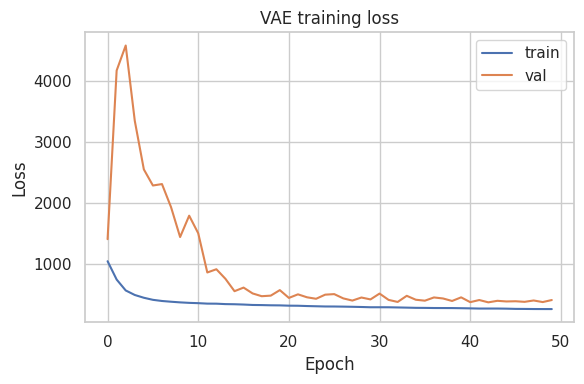

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'], label='train')
if 'val_loss' in hist.history:
    plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE training loss')
plt.legend()
plt.tight_layout()
plt.show()

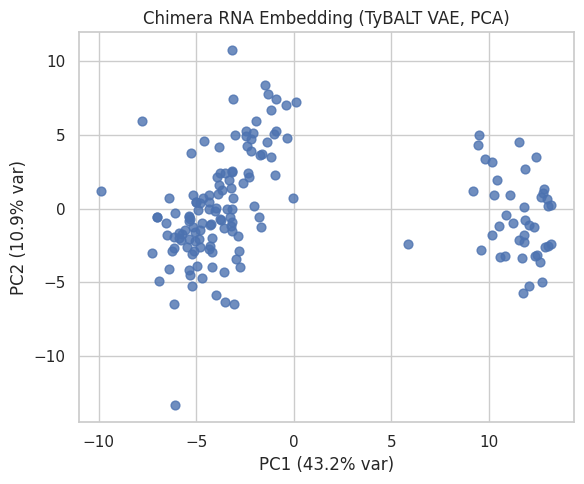

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Zdf: (163, 100)
Z = Zdf.values

# PCA → 2D
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Z)

pca_df = pd.DataFrame(
    Z_pca,
    index=Zdf.index,
    columns=["PC1", "PC2"]
)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=40, alpha=0.8)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Chimera RNA Embedding (TyBALT VAE, PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# -------------------------
# (10) Save per-patient RNA embeddings as .pt files
# -------------------------
import torch
import os

pt_dir = "/content/results/rna_embeddings_pt"
os.makedirs(pt_dir, exist_ok=True)

for patient_id, row in Zdf.iterrows():
    embedding_tensor = torch.tensor(row.values, dtype=torch.float32)

    payload = {
        "patient_id": patient_id,
        "rna_embedding": embedding_tensor  # shape [100]
    }

    out_path = os.path.join(pt_dir, f"{patient_id}.pt")
    torch.save(payload, out_path)

print("✅ Per-patient .pt embeddings saved to:", pt_dir)
print("Example file:", os.path.join(pt_dir, f"{Zdf.index[0]}.pt"))

✅ Per-patient .pt embeddings saved to: /content/results/rna_embeddings_pt
Example file: /content/results/rna_embeddings_pt/3A_001.pt
